In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, DepthwiseConv2D, BatchNormalization, 
                                    Activation, Add, GlobalAveragePooling2D, 
                                    Dense, Dropout, Multiply, Input, LSTM, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100

# Dataset Paths
base_path = '/kaggle/input/skin-cancer-malignant-vs-benign'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Verify paths
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Train directory not found at {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found at {test_dir}")

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data flows
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    class_mode='categorical', subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    class_mode='categorical', subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    class_mode='categorical', shuffle=False
)

# Calculate class weights
class_labels = train_data.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(class_labels), y=class_labels
)
class_weights = dict(zip(np.unique(class_labels), class_weights))

# Swish activation
def swish(x):
    return x * tf.nn.sigmoid(x)

# MBConv block
def mb_conv_block(inputs, filters, kernel_size, strides, expansion_factor, se_ratio=0.25, dropout_rate=0):
    expanded_filters = int(inputs.shape[-1] * expansion_factor)
    if expansion_factor != 1:
        x = Conv2D(expanded_filters, 1, padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
    else:
        x = inputs
    x = DepthwiseConv2D(kernel_size, strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    if se_ratio:
        se_filters = max(1, int(x.shape[-1] * se_ratio))
        se = GlobalAveragePooling2D()(x)
        se = Dense(se_filters, activation='swish')(se)
        se = Dense(x.shape[-1], activation='sigmoid')(se)
        x = Multiply()([x, se])

    x = Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if x.shape[-1] == inputs.shape[-1] and strides == 1:
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
        x = Add()([x, inputs])
    return x

# Fused block
def fuse_conv_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    return x

# Build model
def build_efficientnet_v2(input_shape=(224, 224, 3), num_classes=8):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    x = mb_conv_block(x, filters=16, kernel_size=3, strides=1, expansion_factor=1)
    x = mb_conv_block(x, filters=24, kernel_size=3, strides=2, expansion_factor=4)
    x = mb_conv_block(x, filters=24, kernel_size=3, strides=1, expansion_factor=4)
    x = mb_conv_block(x, filters=48, kernel_size=3, strides=2, expansion_factor=4)
    x = mb_conv_block(x, filters=48, kernel_size=3, strides=1, expansion_factor=4)
    x = mb_conv_block(x, filters=64, kernel_size=3, strides=2, expansion_factor=4)
    x = mb_conv_block(x, filters=64, kernel_size=3, strides=1, expansion_factor=4)

    x = fuse_conv_block(x, filters=128, kernel_size=3, strides=1)
    x = fuse_conv_block(x, filters=160, kernel_size=3, strides=2)
    x = fuse_conv_block(x, filters=160, kernel_size=3, strides=1)

    x = Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)

    # Add LSTM after reshaping
    x = Reshape((1, x.shape[-1]))(x)
    x = LSTM(128, return_sequences=False)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Build and compile the model
model = build_efficientnet_v2(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=train_data.num_classes)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model.fit(
    train_data, epochs=EPOCHS, validation_data=val_data, 
    class_weight=class_weights, verbose=1
)

# Save the model
model.save('custom_efficientnet_with_lstm.h5')


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 701ms/step - accuracy: 0.7475 - loss: 0.5072 - val_accuracy: 0.5465 - val_loss: 0.7153
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 486ms/step - accuracy: 0.7928 - loss: 0.4132 - val_accuracy: 0.5465 - val_loss: 0.7569
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 492ms/step - accuracy: 0.8110 - loss: 0.3903 - val_accuracy: 0.5465 - val_loss: 0.9558
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 485ms/step - accuracy: 0.8228 - loss: 0.3718 - val_accuracy: 0.5465 - val_loss: 1.1472
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - accuracy: 0.8292 - loss: 0.3469 - val_accuracy: 0.5465 - val_loss: 1.5110
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 482ms/step - accuracy: 0.8341 - loss: 0.3381 - val_accuracy: 0.5465 - val_loss: 2.1659
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 493ms/step - accuracy: 0.8249 - loss: 0.3457 - val_accuracy: 0.5465 - val_loss: 1.4986
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 485ms/step - accuracy: 0.8404 - loss: 0.3315 - val_accuracy

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.90      0.85      0.87       360
   malignant       0.83      0.89      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



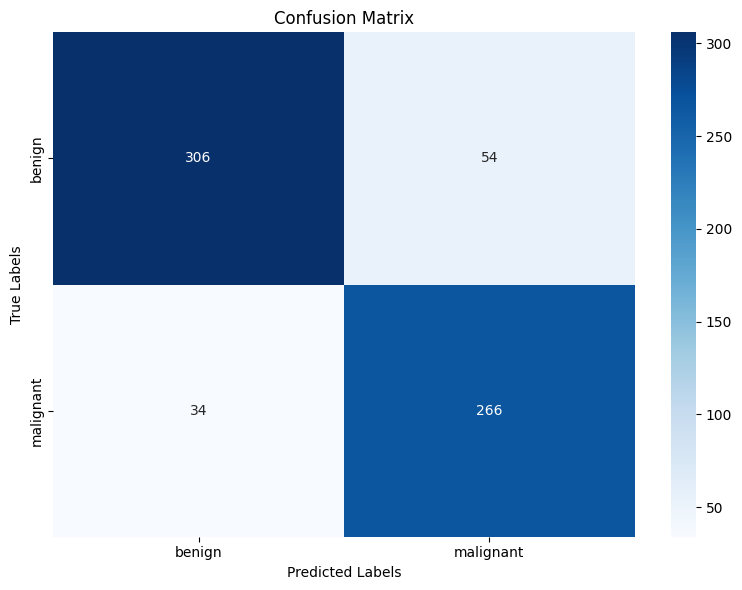

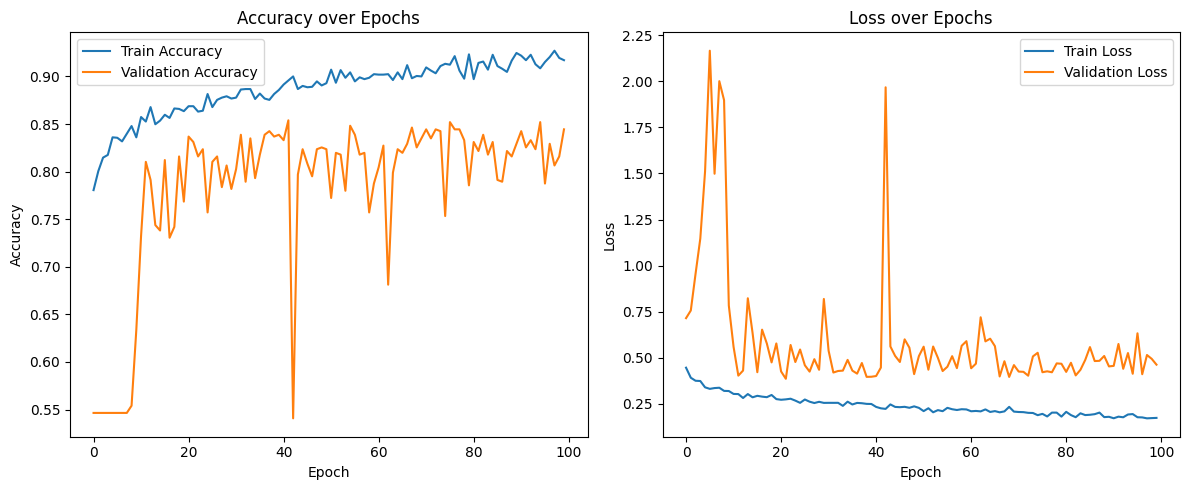

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Predict on Test Set ---
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# --- 2. Classification Report ---
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 3. Confusion Matrix ---
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Accuracy and Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
